In [ ]:
%matplotlib inline
%autoreload 2

from tonic.io import read_config, read_netcdf
import xarray as xr
import pandas as pd
import numpy as np
import argparse
import os
import matplotlib.pyplot as plt
from general_functions import datestamp
from collections import OrderedDict

In [54]:
# parser = argparse.ArgumentParser(formatter_class=argparse.RawTextHelpFormatter)
# parser.add_argument("config_file",help="input config file")
# args = parser.parse_args()
# config_file = args.config_file

# Read in the config file (TODO: make this a command line argument by uncommenting the lines above)
config_file = 'spatial_comparisons.cfg'
config_dict = read_config(config_file)

# Read in the strings used to identify/describe the data contained in file1
options = config_dict.pop('Global')
out_dir = options['figure_dir']
file1_options = config_dict.pop('Options_file1')
# The remaining pieces of the config_dict are the variables and their information
variables = config_dict

In [ ]:
os.makedirs(out_dir, exist_ok=True)

In [ ]:
ds = xr.open_dataset(file1)

In [ ]:
monthly_plot_setup= OrderedDict([('January', ((0,0),0)), ('February', ((0,1),1)), 
                                 ('March', ((0,2),2)), ('April',((0,3),3)), 
                                 ('May', ((1,0),4)), ('June', ((1,1),5)), 
                                 ('July', ((1,2),6)), ('August', ((1,3),7)),
                                 ('September', ((2,0),8)), ('October', ((2,1),9)),
                                 ('November', ((2,2),10)), ('December', ((2,3),11))])

In [37]:
# TO-DO:
# Add a file2 and make equivalent figures for it
# Add comparison (difference plots)
# Convert to python script
# 

In [47]:
def calculate_mean_monthly_spatial_field(ds):
    '''
    Input: xarray dataset
    Output: Mean monthly spatial array for dataset 
    '''
    monthly = ds[variable].groupby('time.month').mean(dim='time')
    return monthly

In [59]:
def mean_monthly_spatial_plot(monthly_groupby_arrays, variable, title, units, vmin, vmax, figure_stub):

    '''
    Saves a figure with 12 spatial plots of mean monthly 
    variable fields.
    '''

    monthly_plot_setup= OrderedDict([('January', (0,0)), ('February', (0,1)), 
                                 ('March', (0,2)), ('April', (0,3)), 
                                 ('May', (1,0)), ('June', (1,1)), 
                                 ('July', (1,2)), ('August', (1,3)),
                                 ('September', (2,0)), ('October', (2,1)),
                                 ('November', (2,2)), ('December', (2,3))])
    # Initialize the figure
    f, axarr = plt.subplots(3, 4, figsize=(20,16), sharex=False, sharey=False)
    
    # Cycle through the months in the setup dictionary defined above and put the plots in the
    # correct location in the plot according to the items in the dictionary
    for i,month in enumerate(monthly_plot_setup.keys()):
        ax = plt.sca(axarr[monthly_plot_setup[month]])
        plot = monthly_groupby_arrays[i].plot(ax=ax, vmin=vmin, vmax=vmax, add_colorbar=False)
        
    # Assign a title based upon the setup dictionary defined above
        plt.title(month, size=20)
        
    # Make room for a title and a colorbar
    f.subplots_adjust(left=0.12, right=0.9, top=0.93)

    # Plot a colorbar on the left side of the plot
    cbar_ax_abs = f.add_axes([0.045, 0.15, 0.014, 0.8])
    cbar_ax_abs.tick_params(labelsize=20)
    cbar_abs = plt.colorbar(plot, cax=cbar_ax_abs, extend='max').set_label(label=(' ').join([variable,units]),
                                                                           size=30, labelpad=-100)
    # Add a colorbar
    plt.suptitle((' ').join([title, 'mean monthly spatial fields']), size=30)
    f.savefig(os.path.join(out_dir, ('_').join([datestamp(),figure_stub,variable+'.png'])))

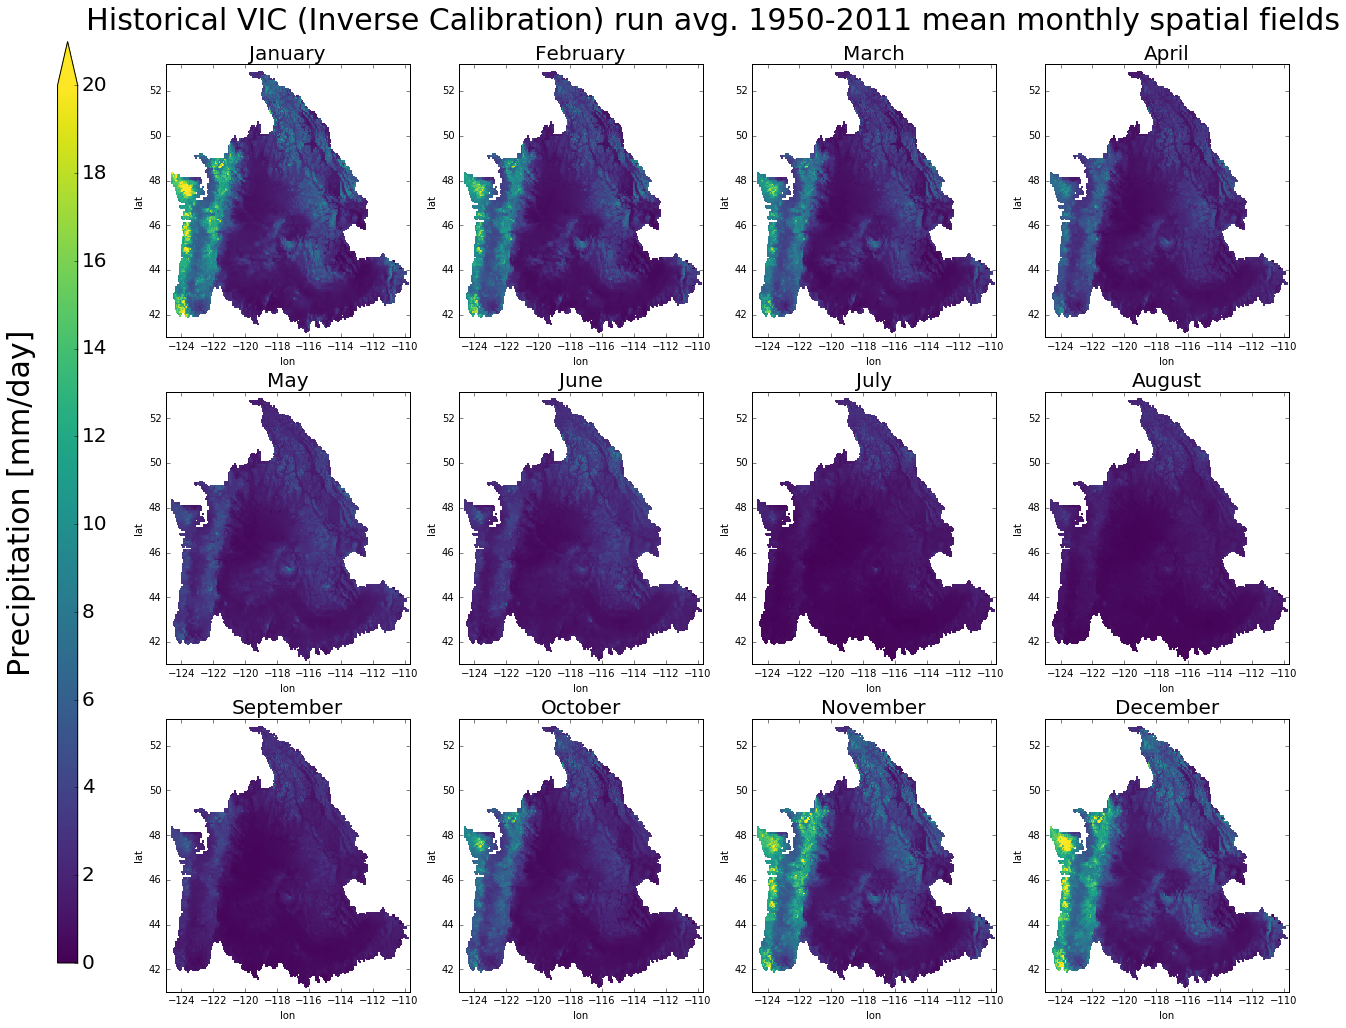

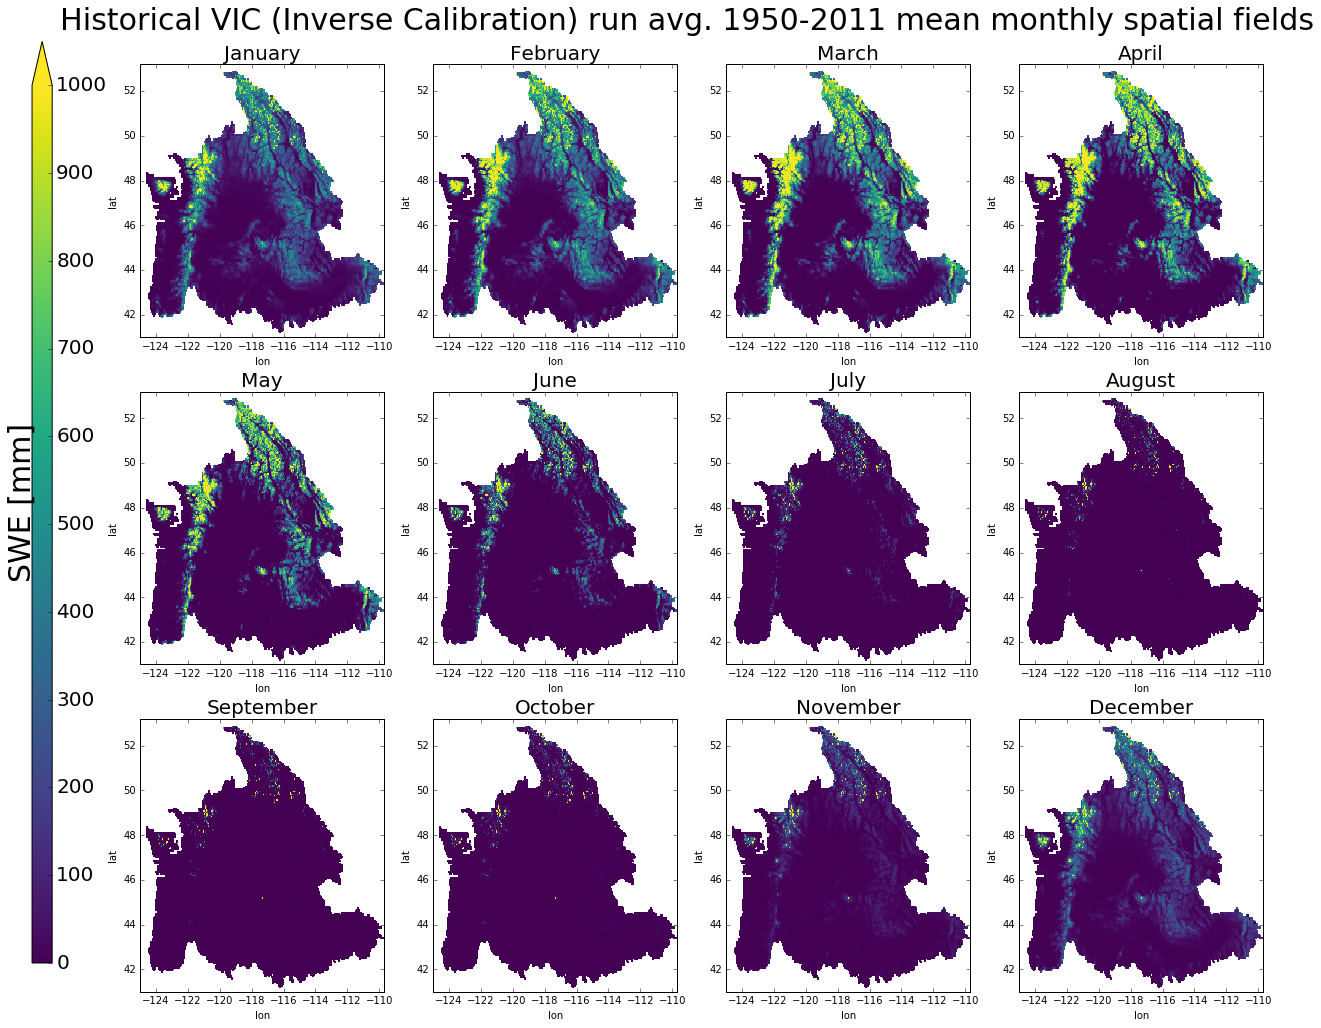

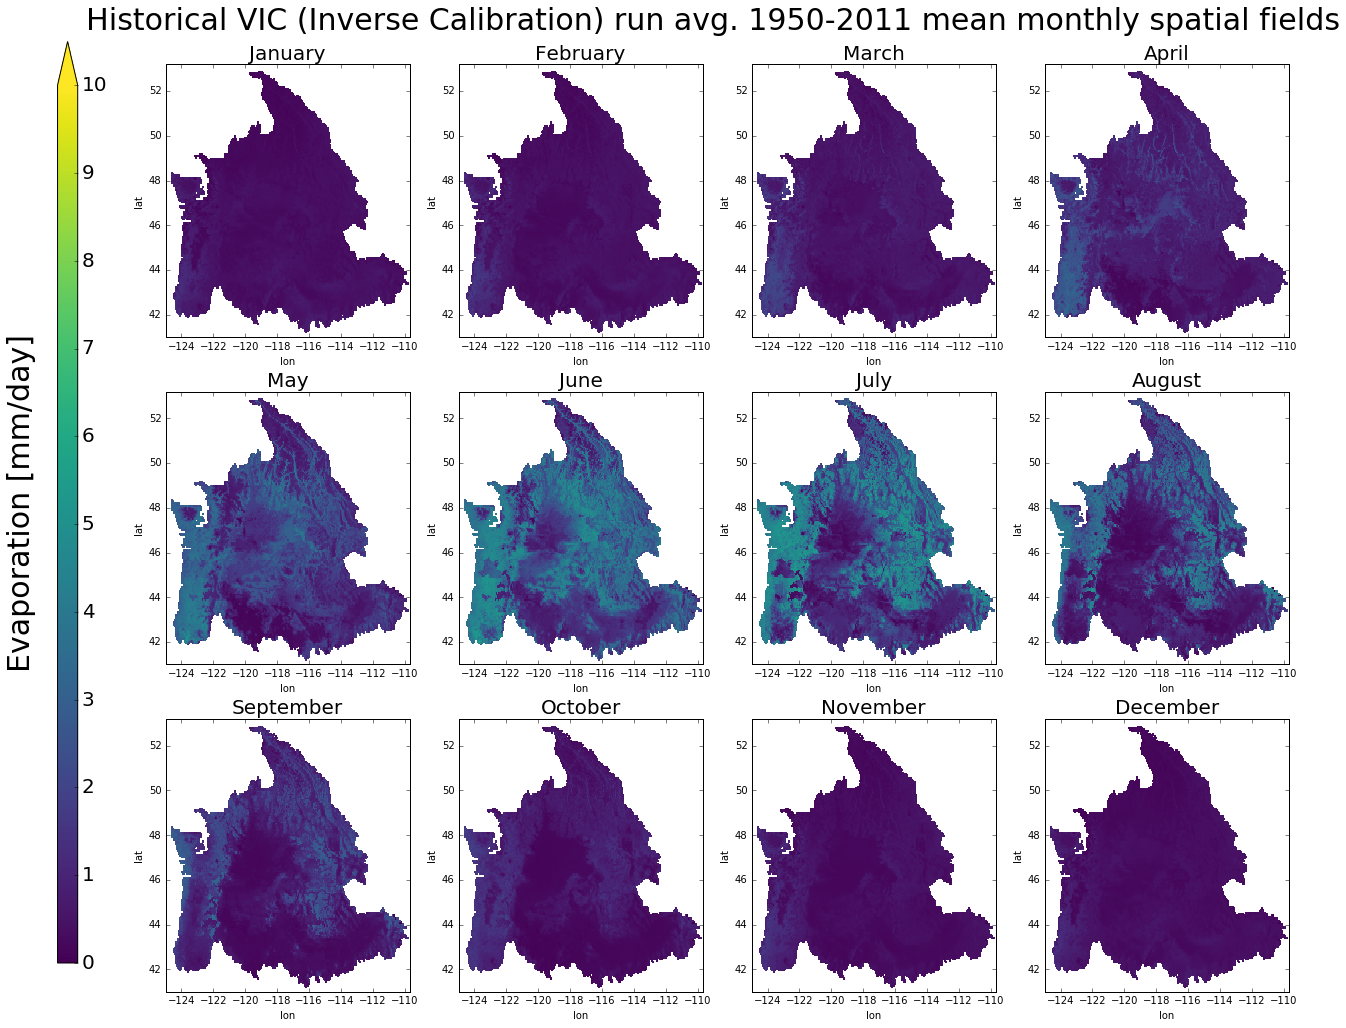

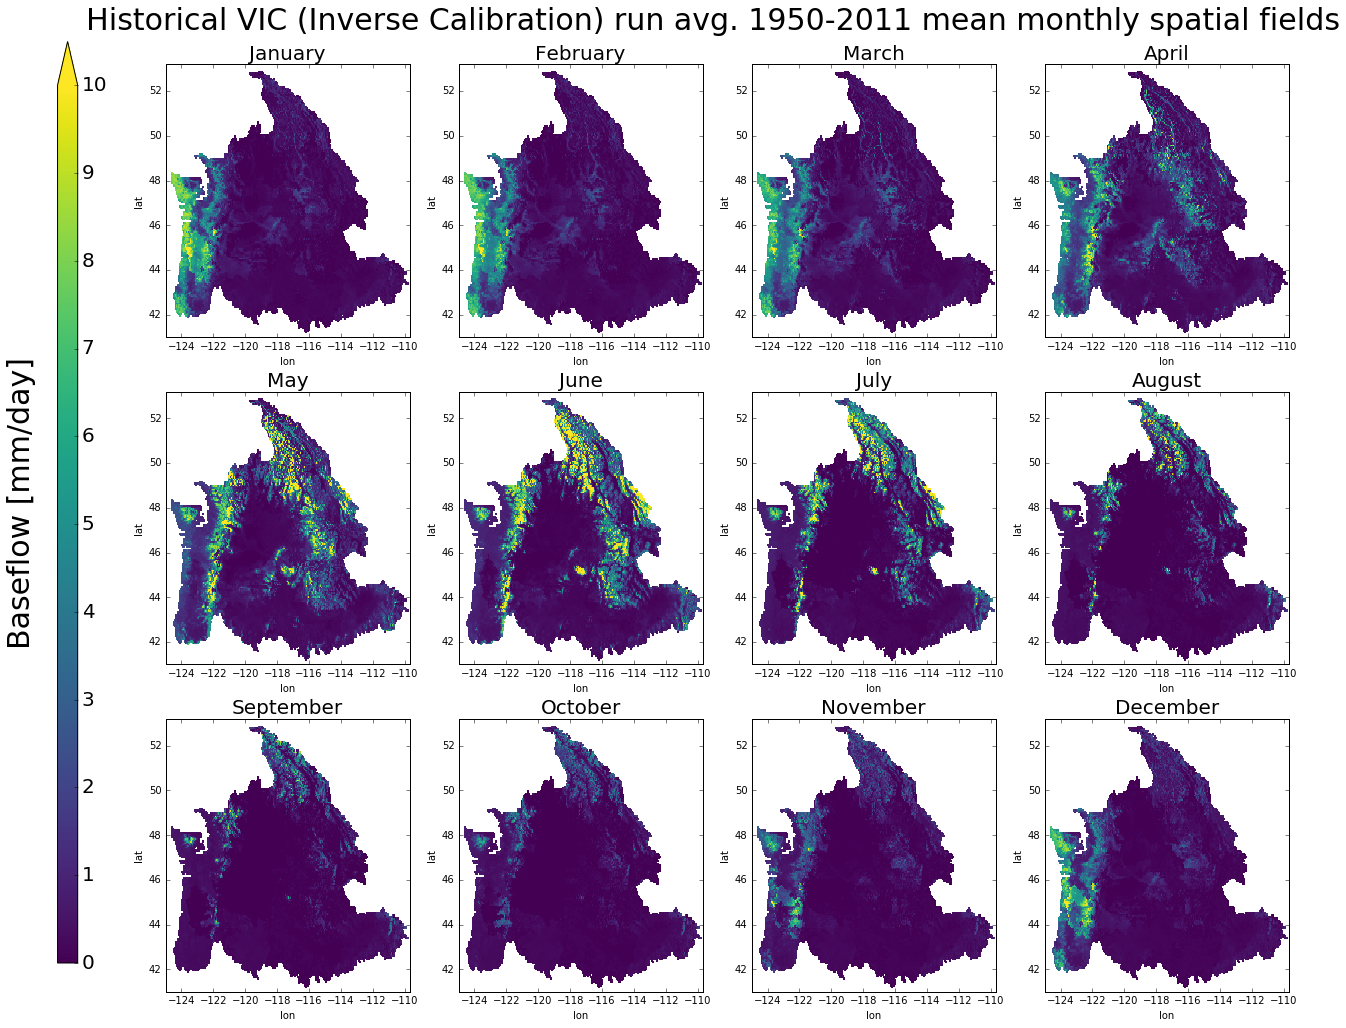

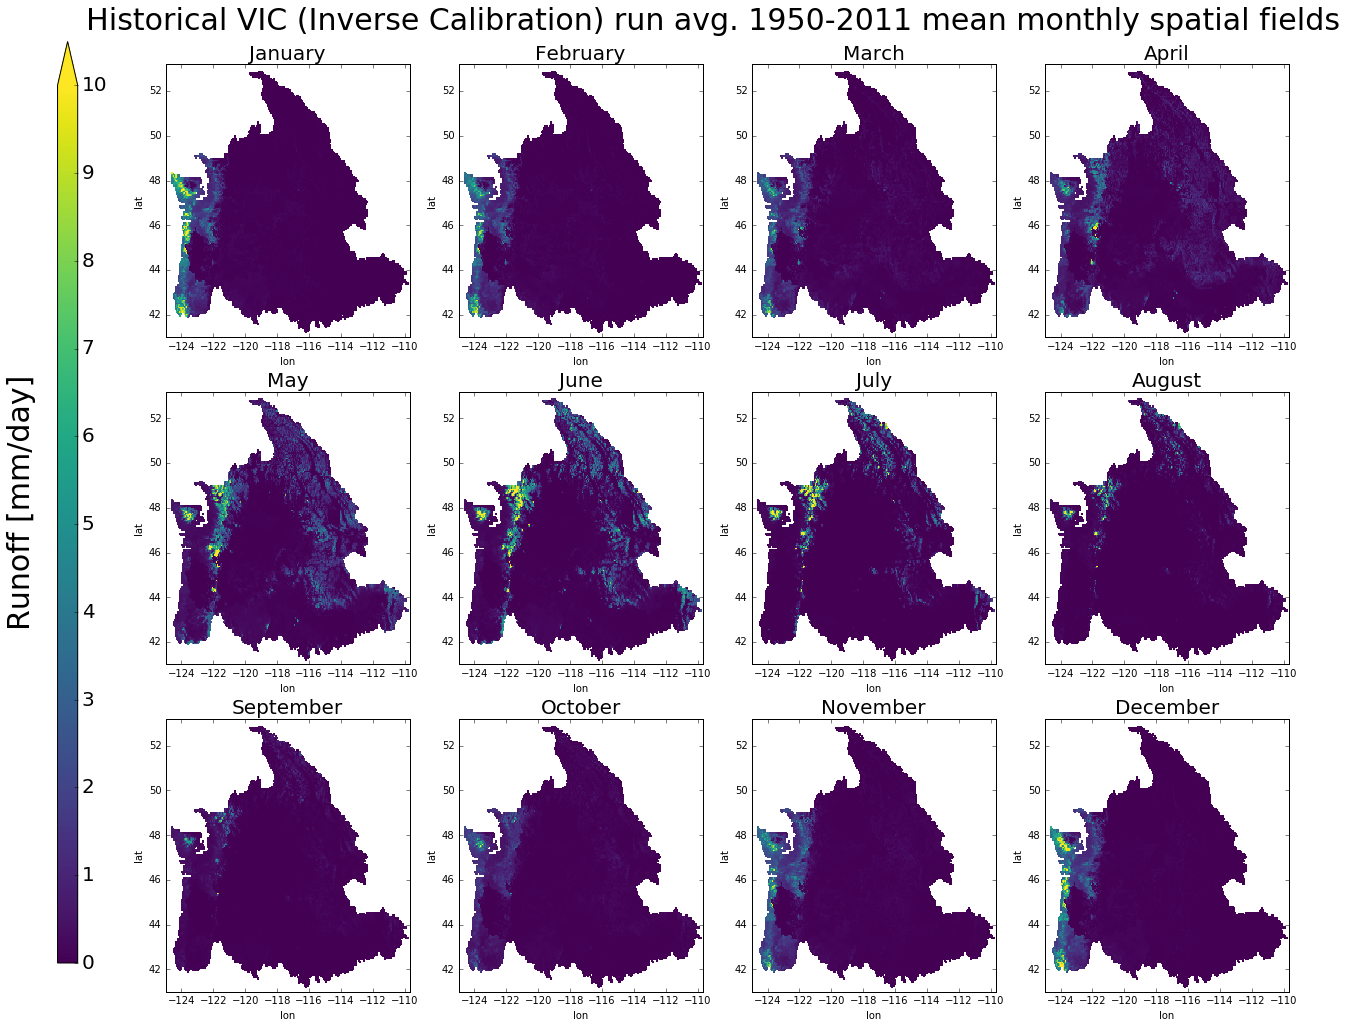

In [60]:
# Access the title and figure stub (same for all varaibles' plots)
title = file1_options['description']
figure_stub = file1_options['figure_stub']

# Loop through the variables and create a plot for each of them
for variable in variables.keys():
    
    # Get the groupby'ed mean monthly arrays
    monthly = calculate_mean_monthly_spatial_field(ds)
    
    # Access the units and vmax/vmin which differ for every variable
    option_dict = variables[variable]
    units, vmin, vmax = option_dict['units'], option_dict['vmin'], option_dict['vmax']
    
    # Make the plot!
    mean_monthly_spatial_plot(monthly, variable, title, units, vmin, vmax, figure_stub)